# Quantum Machine Learning. Regressor

Quantum Machine Learning is one the the possible applications of Quantum Computing. This exercise is based on the paper [Mitarai K, Negoro M, Kitagawa M, Fujii K. Quantum circuit learning. Phys Rev A. 2018;98(3):032309.](https://arxiv.org/abs/1803.00745)

The example is based on [QCL page](http://dkopczyk.quantee.co.uk/qcl/), where a good description of the method is provided. However, to speedup the execution, instead the usual gradient descend algorithm for Machine Learning, a faster optimisation algorithm is used [Conjugate Gradient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html)

The steps of the algorithm are:

1. Starting from state $|0\rangle$ and an case with input data ${x_i}$ of the dataset ($X$,$Y$), generate an initial Quantun State $|\Psi({x_i})>$ on the desired number of qubits (which can be larger than the number of input data for a single case). The amplitudes of this Quantum State are the input quantum features of the Machine Learning Model.
2. Apply $n$ times a combination of a random Time Evolution of one operator plus a set of parameterised rotations on each qubits.
3. Measure the expectation value of one operator of subset of Pauli operators $\{B_j\} \subset {\{I,X,Y,Z\}}^{\otimes N}$. This measurement will be the prediction $y_i$ for this input data ${x_i}$.
4. Minimize the cost function which compares the labels $Y$ with the predictions $y$.


Import the needed operations from ProjectQ

In [1]:
from projectq.cengines import MainEngine
from projectq.backends import Simulator
from projectq.ops import Z,X,H,Rx,Ry,Rz,All,Measure

Generate a dataset which follows the funcion $f(x)=x^2$ on the interval $[-1,1]$. This restriction on the input values does not limit the model, because in Classical Machine Learning, usually the input and output data are normalised as a first step.
Select the number of cases of the dataset assigning a value to P (take into account that a large number means long simulations)

In [2]:
import numpy as np
P=20
data_in=np.linspace(-1,1,P)
data_out=data_in*data_in

To inicialise the state (step 1), apply $R_z(cos^{-1}(x^2))R_y(sin^{-1}(x))$ to all qubits of the Quantum Register. Any other inicialisation is possible. If N i sthe number of qubits, the new state is:

$$|\Psi(x)>= (R_z(cos^{-1}(x^2))R_y(sin^{-1}(x))|0>)^{\otimes N}$$

In [3]:
def Uinit(qreg,x):
    import math
    theta_1=math.acos(x*x)
    theta_2=math.asin(x)
    All(Ry(theta_2)) | qreg
    All(Rz(theta_1)) | qreg


Create now the Unitary operation **U** to train. It receives as input the qubits in a Quantum Register (*qreg*) and an array with the parameters of the rotations which define this unitary operation.

For this case, to **each** qubit apply three rotations

$$R_x(\theta_{1j})R_z(\theta_{2j})R_x(\theta_{3j})$$ 

where $j$ is the index of the qubit. So, $\Theta =\{\theta_{ij}\}$ is an array of paramenters to train of dimensions $[3,N]$, where N is the number of qubits

In [4]:
def U(qreg,theta):
    for index,q in enumerate(qreg):
            Rx(theta[0,index]) | q
            Rz(theta[1,index]) | q
            Rx(theta[2,index]) | q

Before this Unitary operation, the state will evolve during a selected time **T** using a Hamiltonian which follows a fully connected transverse Isin model:

$$H = \sum_{j=1}^{N}\alpha_j X_j + \sum_{j=1}^{N}\sum_{k=1}^{j-1}J_{jk}Z_jZ_k$$

where $N$ is the number of qubits. The free parameters $\alpha_j$ and $J_{jk}$ are taken randomly from \[-1,1\]. Take into account that these parameters are part of the model to save, but are not trained.

To define the Hamiltonian, first you have to select the number of qubits in the register $N$

**NOTE**: if you want to repete several times the exercise and have the same results, use this set of parameters for the Hamiltonian instead of inicialise them randomly. For N=3, D=6 and T=10

alpha=np.array([ 0.08602005, 0.31794106, -0.64280023])

J=np.array([ -0.23099109,-0.67899721, 0.33369254])

In [5]:
N=3

In [6]:
from projectq.ops import QubitOperator

In [7]:
alpha=(np.random.rand(N)-0.5)*2.0
J=(np.random.rand(N*(N-1)//2)-0.5)*2.0
Hamiltonian=None
k=0
for j in range(N):
    if (Hamiltonian is None):
        Hamiltonian=alpha[j]*QubitOperator("X%d"%j)
    else:
        Hamiltonian=Hamiltonian+alpha[j]*QubitOperator("X%d"%j)

    for i in range(j):
        Hamiltonian=Hamiltonian+J[k]*QubitOperator("Z%d Z%d"%(j,i))
        k=k+1


In [8]:
from projectq.ops import TimeEvolution

Now it is time to compose the final circuit. The graphical representation of the circuit is:

<img src="Images/QCL.jpg" width="60%"/>

The function receives:
1. **x** that is the input data for this case
2. **Theta** a vector the dimension 3\*N+1. Last element multiplies the expectation value before exit the function.
3. **N**, the number of qubits 
4. **D**, the number of times to repeat the evolution
5. **T**, the time to evolve th Hamiltonian
6. **H**, the Hamiltonian

The output must be the expectation value of $\sigma_z$ for qubit **0** multiplied by the parameter Theta\[-1\]

Hint: Use the ProjectQ methods:
1. [QubitOperator](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.QubitOperator)
2. [TimeEvolution](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.TimeEvolution)
3. [get_expectation_value](https://projectq.readthedocs.io/en/latest/projectq.backends.html#projectq.backends.Simulator)

In [9]:
def qfun(x,Theta,N,D,T,H):
    theta1=Theta[0:3*N].reshape(3,-1)

    eng=MainEngine(backend=Simulator(gate_fusion=True, rnd_seed=1000))
    qreg=eng.allocate_qureg(N)  
    
    Uinit(qreg,x)
    
    for i in range(D):
        TimeEvolution(time=T,hamiltonian=H) | qreg
        U(qreg,theta1)
    
    eng.flush()
    
    energy=eng.backend.get_expectation_value(QubitOperator("Z0"),[qreg[0]])
    
    All(Measure) | qreg
    eng.flush()
    del eng
    
    return Theta[-1]*energy
    

OK. Define the loss for the training:

$$loss = \frac{1}{m}\sum_{i=1}^m{(qfun(x_i)-y_i)}^2$$

where $m$ is the number of cases and $y_i$ is the label for case $i$

In [10]:
def loss(Theta,data_in,data_out,N,D,T,H):
    fun_out=0
    for i in range(len(data_in)):
        x=data_in[i]
        y=data_out[i]
        y_pred=qfun(x,Theta,N,D,T,H)
        fun_out+=(y_pred-y)**2
        
    return fun_out/len(data_in)

If you want to use an optimisation method that needs the Jacobian, this function canculates it

In [11]:
def jacobian(Theta,data_in,data_out,N,D,T,H):
    import random
    import math
    fun_out=np.zeros(len(data_in))
    for i in range(len(data_in)):
        x=data_in[i]
        y=data_out[i]
        y_pred=qfun(x,Theta,N,D,T,H)
        fun_out[i]=(y_pred-y)
    grad=np.zeros(len(Theta))
    for j in range(len(Theta)):
        grad[j]=0.
        for i in range(len(data_in)):
            x=data_in[i]
            Theta_in=Theta
            Theta_in[j]=Theta[j]+(math.pi*0.5)
            bplus=qfun(x,Theta_in,N,D,T,H)
            Theta_in[j]=Theta[j]-(math.pi*0.5)
            bminus=qfun(x,Theta_in,N,D,T,H)
            grad[j]+=(bplus-bminus)*fun_out[i]
    
    grad=grad/len(data_in)
    print("Grad=",grad)
    return grad


Initialise the training parameters. The angles of the rotations must be selected randomly in the interval $[0,2\pi]$, meanwhile the factor of the expectation value is initialised to 1.0

Select also the number of repetitions (D) and the time for the Hamiltonian evolution (T)

**Hint**: if you want to speedup the convergence, use these pre-trained values for N=3, D=6 and T=10.

Theta= np.array(\[3.31796403, 0.87953786, 4.83513721, 1.24258299, 5.22865892, 5.62510395,
 1.48305738, 4.32426944, 0.61991344, 1.92099828\])
 
 and select the number of iterations to 10


In [12]:
import math
D=6
T=10

Theta=np.random.rand(3*N+1)
Theta[0:3*N]=math.pi*2.*Theta[0:3*N]
Theta[-1]=1.0
print("The value of the initial loss is =",loss(Theta,data_in,data_out,N,D,T,Hamiltonian))

The value of the initial loss is = 0.47079917387851633


Plot the initial form of the proposed function.

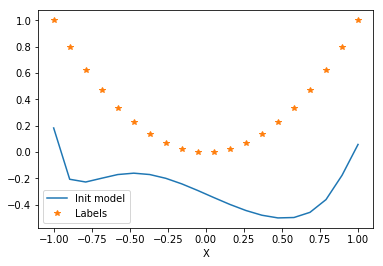

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,label="Init model")
plt.xlabel("X")
plt.plot(data_in,data_out,"*",label="Labels")
plt.legend()
plt.show()

This is a callback function to show how the training evolves. **Just execute the next cell without changes**

In [14]:
def callback(xk):
    cost=loss(xk,data_in,data_out,N,D,T,Hamiltonian)
    out=[qfun(j,xk,N,D,T,Hamiltonian) for j in data_in]
    plt.plot(data_in,out,"b",label="Cost=%.4f"%cost)
    plt.plot(data_in,data_in*data_in,"*",label="Labels")
    out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
    plt.plot(data_in,out,"r",label="First")
    plt.xlabel("X")
    plt.legend()
    plt.show()
    print("Cost=",cost)
    print("Theta=",xk)
    return False

Ok. Now train the model. Select the number of iterations in maxiter

Use the minimize method with "Conjugate Gradient" as algorithm of minimisation. Do not forget to add the callback, so you can follow the training evolution.

**Hint**: [Minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

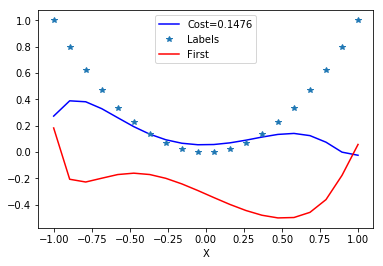

Cost= 0.1476448204280385
Theta= [5.14250317 6.19505133 2.50151459 2.16745969 3.93576294 1.87822825
 1.45622918 1.01521563 5.65425504 0.76426044]


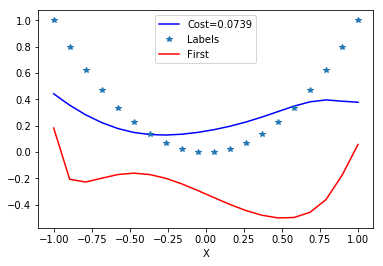

Cost= 0.07392828972803382
Theta= [5.05658723 6.36738622 2.58105354 2.00614184 3.90749655 1.90847454
 1.6197117  0.88033576 5.60681278 0.80643811]


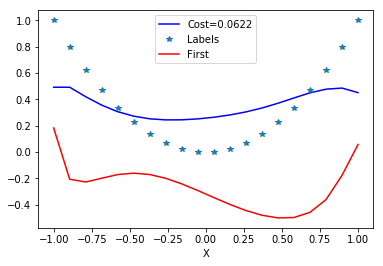

Cost= 0.062150980043242855
Theta= [5.00171185 6.38317998 2.62337901 1.9989814  3.86310556 1.92425897
 1.62144634 0.86622762 5.58704575 0.8552086 ]


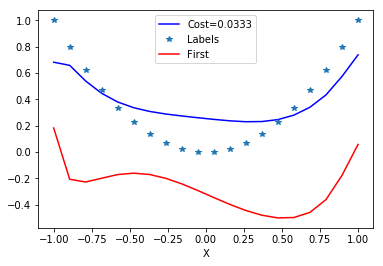

Cost= 0.03328515592947402
Theta= [4.82887778 6.36849553 2.75928966 1.88021348 3.89796445 1.96817913
 1.64020826 0.82740041 5.60617449 1.01232821]


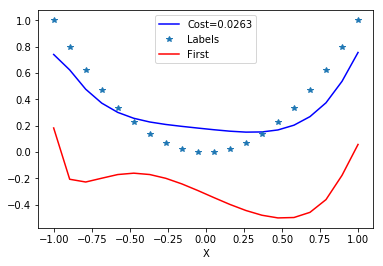

Cost= 0.026284927277175397
Theta= [4.81588898 6.3529441  2.76573301 1.85441853 3.92592533 1.96009386
 1.65470715 0.83037508 5.62944352 1.03573595]


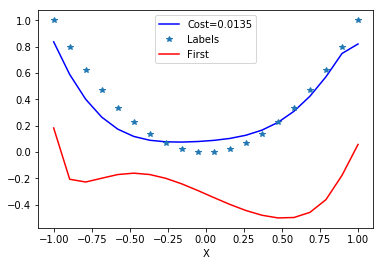

Cost= 0.013466263114503501
Theta= [4.80921679 6.32934031 2.71551749 1.85224988 3.85403146 1.8787069
 1.73760796 0.88080243 5.72769957 1.20274666]


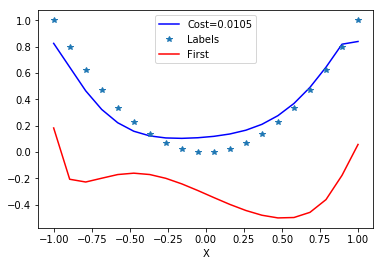

Cost= 0.010474649610656984
Theta= [4.79621863 6.32637478 2.71761815 1.86467991 3.81830168 1.86915283
 1.74952839 0.89231587 5.74950666 1.25931652]


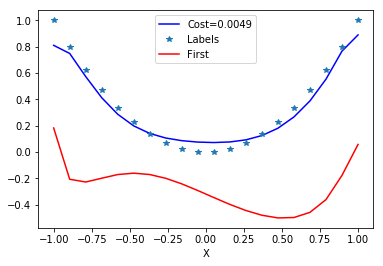

Cost= 0.004899833030624415
Theta= [4.76279822 6.30539981 2.76991141 1.8705455  3.83154405 1.89440062
 1.73963252 0.90253257 5.77483651 1.30972573]


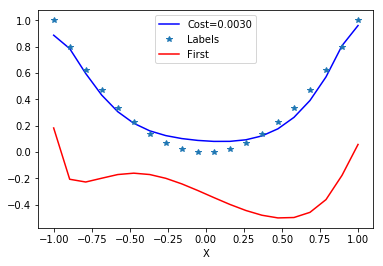

Cost= 0.003044898220193204
Theta= [4.74841286 6.32216924 2.78372378 1.86662248 3.84164591 1.88954604
 1.74832166 0.88982641 5.76887454 1.36268919]


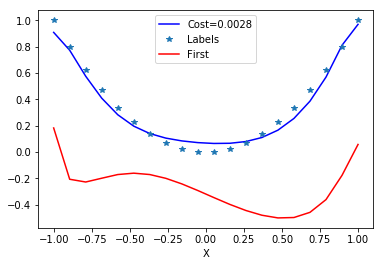

Cost= 0.0027658990060546867
Theta= [4.74888509 6.32338277 2.78111368 1.86285342 3.84636315 1.88523198
 1.75281289 0.88964323 5.77052936 1.37069318]


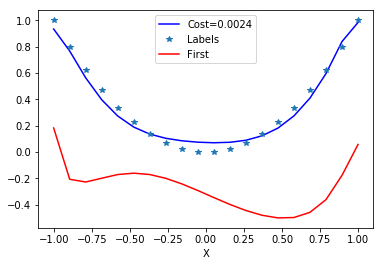

Cost= 0.0024271164837493726
Theta= [4.75071057 6.33041175 2.7755354  1.86200194 3.84494395 1.87900967
 1.75962043 0.88743071 5.76974385 1.38891163]


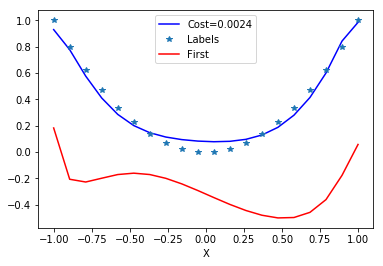

Cost= 0.0023532132333992195
Theta= [4.7501805  6.33099955 2.77700106 1.86437027 3.84286601 1.8809884
 1.7587125  0.88744892 5.76980565 1.39205086]


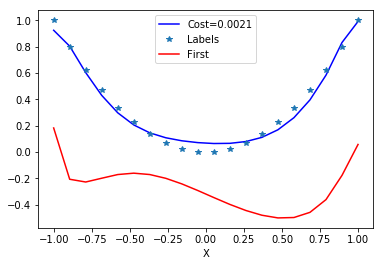

Cost= 0.0021060639501758816
Theta= [4.74809603 6.32622605 2.78358686 1.86993107 3.84598619 1.88953777
 1.75821482 0.89315901 5.77983046 1.41230209]


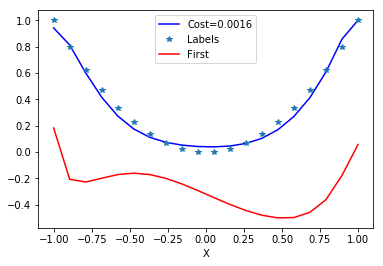

Cost= 0.0016156048224226487
Theta= [4.75796864 6.32589643 2.77287594 1.87839628 3.84468288 1.89215689
 1.77095266 0.90500127 5.80097056 1.46774961]


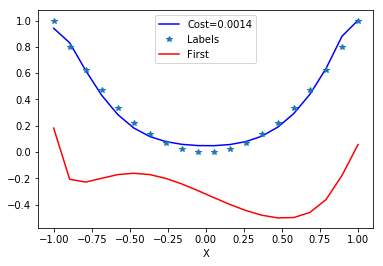

Cost= 0.0013648928383539764
Theta= [4.76302057 6.32845767 2.76816428 1.88631788 3.83878525 1.89519948
 1.77580836 0.90940826 5.80909801 1.49669826]


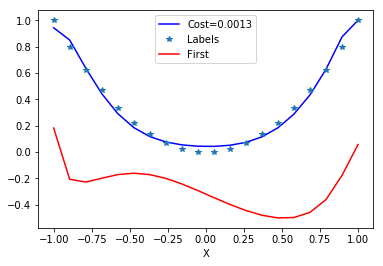

Cost= 0.001301660793786812
Theta= [4.76758518 6.32877037 2.76906227 1.8923317  3.84217303 1.90294112
 1.7751126  0.91130379 5.8172383  1.51581402]


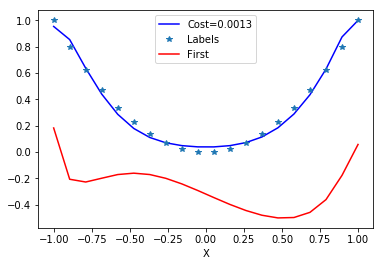

Cost= 0.0012782530195756723
Theta= [4.77285206 6.33071031 2.76591047 1.89415705 3.84488901 1.9051579
 1.77472306 0.9108441  5.82066158 1.52345074]


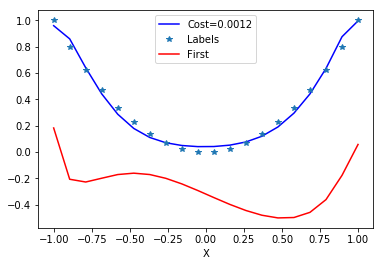

Cost= 0.0012472559507797733
Theta= [4.77824198 6.33358171 2.76274997 1.89708789 3.84596688 1.90769828
 1.77372562 0.90977518 5.82308771 1.53076293]


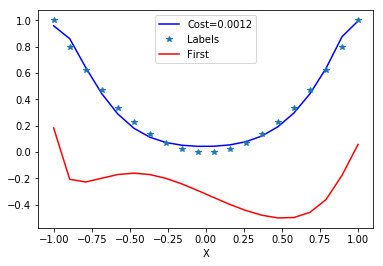

Cost= 0.001244241428638865
Theta= [4.77850601 6.33385826 2.76268516 1.89766017 3.84584017 1.90801342
 1.7731431  0.90950049 5.82288552 1.53045249]


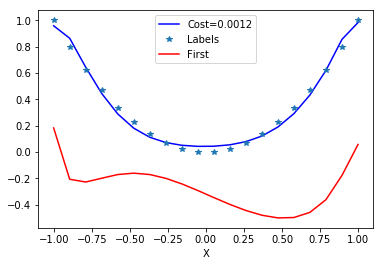

Cost= 0.0012041193837074855
Theta= [4.78546904 6.33574225 2.75890654 1.90356305 3.85322331 1.91198335
 1.76298288 0.90581855 5.82331213 1.52292932]


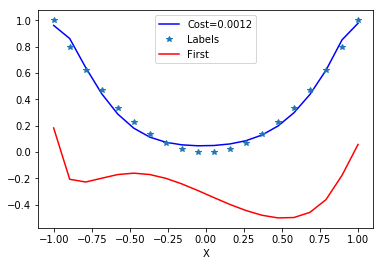

Cost= 0.0011839512509454382
Theta= [4.79023073 6.33902515 2.75376273 1.90726388 3.8565555  1.91212753
 1.75730393 0.9025844  5.8218586  1.51871885]


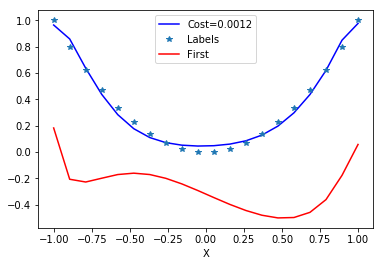

Cost= 0.0011766779745319398
Theta= [4.79174384 6.33993494 2.75169892 1.90799084 3.85858341 1.91171081
 1.75566747 0.90160738 5.82160374 1.5174206 ]


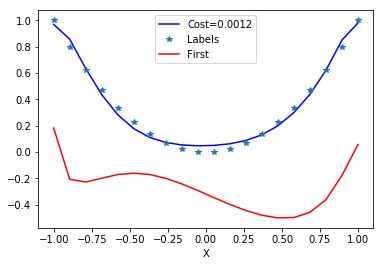

Cost= 0.00116691088949063
Theta= [4.79120479 6.34188417 2.74936342 1.90973255 3.86099937 1.91034044
 1.75376519 0.90003297 5.81993259 1.51739395]


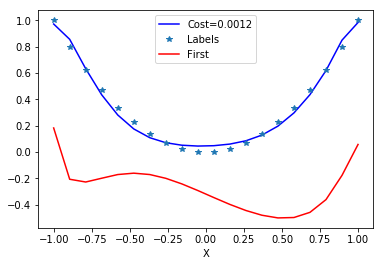

Cost= 0.0011615645141186829
Theta= [4.79019668 6.34229196 2.74848868 1.910624   3.86330569 1.90968625
 1.75275944 0.89959631 5.8194559  1.51766377]


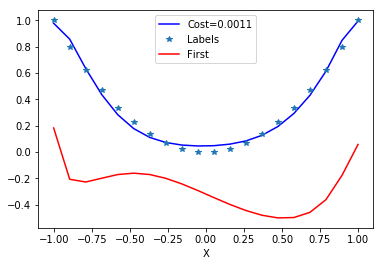

Cost= 0.001149086797842209
Theta= [4.78578942 6.34419812 2.74598683 1.9153135  3.86960151 1.90799773
 1.74868881 0.89799266 5.81695295 1.51898533]


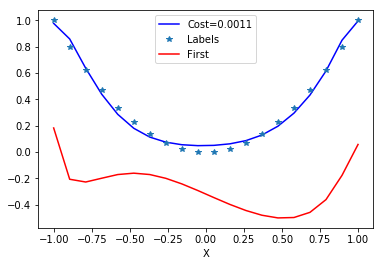

Cost= 0.001144511496193566
Theta= [4.78528225 6.34456605 2.74557316 1.91626079 3.86955718 1.9078801
 1.74818077 0.8978745  5.81646559 1.51915606]


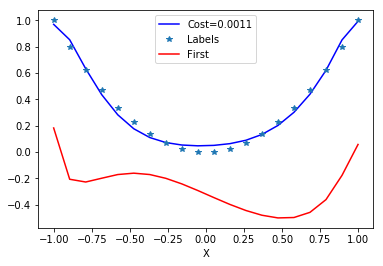

Cost= 0.0011268128361132661
Theta= [4.78404563 6.34353043 2.73872902 1.92111894 3.86989495 1.90564186
 1.7473863  0.90112575 5.81680535 1.51947674]


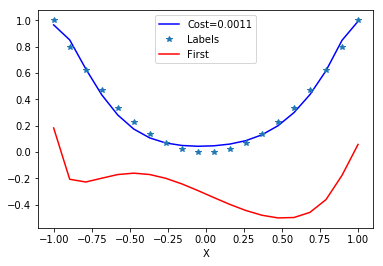

Cost= 0.0011195336523525472
Theta= [4.78281316 6.3422822  2.73665677 1.92359238 3.87128449 1.90557533
 1.74659247 0.90298049 5.81760661 1.51976183]


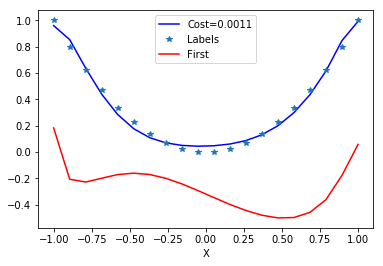

Cost= 0.0011099261424230241
Theta= [4.7811586  6.34138244 2.73493278 1.9268612  3.87197904 1.90595979
 1.74541414 0.9046842  5.8179724  1.52026076]


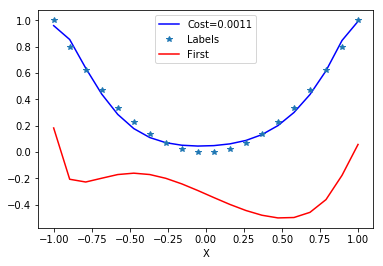

Cost= 0.0011088773859696086
Theta= [4.78093835 6.3416512  2.73493653 1.92706867 3.87188959 1.90602581
 1.74534852 0.90455274 5.81774292 1.52047164]


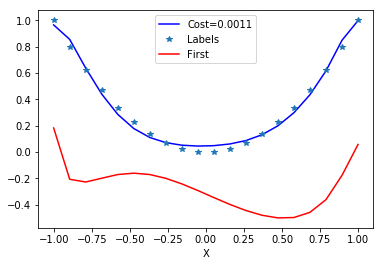

Cost= 0.0011018701046087386
Theta= [4.77899793 6.34320916 2.73442996 1.92752944 3.87397889 1.90610835
 1.74536379 0.90383767 5.81682664 1.52249758]


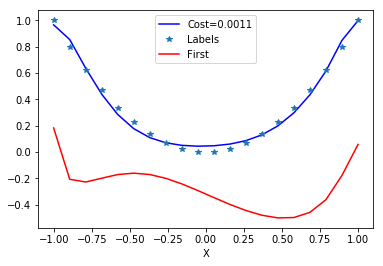

Cost= 0.0011011703478412713
Theta= [4.77894096 6.34324697 2.7338843  1.9277016  3.87437157 1.90614252
 1.74540228 0.90404786 5.8169436  1.52265324]


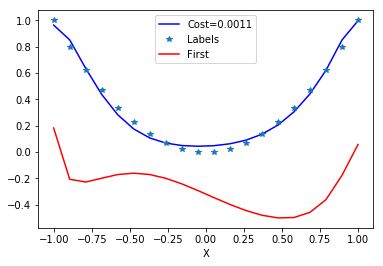

Cost= 0.0010894244590979112
Theta= [4.77690778 6.34603008 2.72368903 1.93426141 3.87787747 1.90817486
 1.7448522  0.90736161 5.81700693 1.52625599]


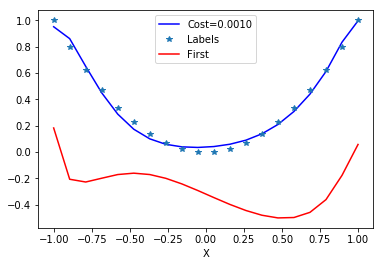

Cost= 0.0010382977596340537
Theta= [4.7615348  6.3568332  2.68232078 1.96964156 3.90205052 1.92577987
 1.7377186  0.92386372 5.81940583 1.54436771]


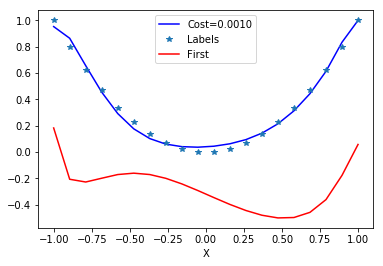

Cost= 0.001026363843671105
Theta= [4.75544266 6.36222588 2.66907727 1.97999193 3.90955153 1.93051455
 1.73597606 0.92749924 5.81856003 1.55042724]


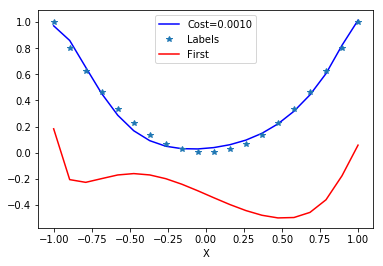

Cost= 0.000977143986972226
Theta= [4.73143412 6.38238497 2.61786748 2.01497646 3.94401813 1.94645978
 1.7315657  0.94055993 5.81643648 1.57318495]


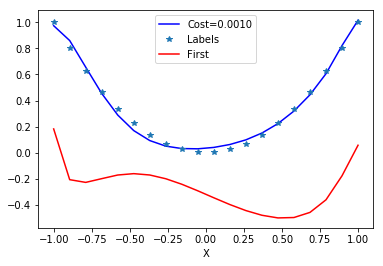

Cost= 0.0009714322311735466
Theta= [4.72738314 6.3858079  2.61031647 2.02044687 3.94875809 1.94899183
 1.73080663 0.94226492 5.81573395 1.57651218]


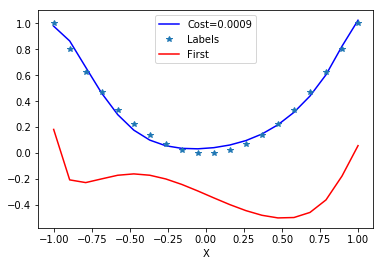

Cost= 0.0009461224236627421
Theta= [4.72094611 6.38739638 2.61307036 2.01947759 3.95024183 1.95032078
 1.73179396 0.93975884 5.8140853  1.57348954]


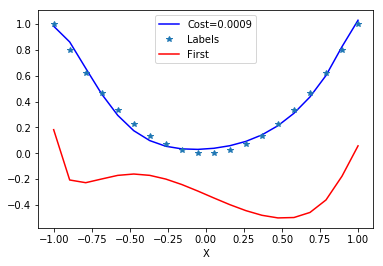

Cost= 0.0009333586475233777
Theta= [4.71777763 6.38789064 2.61361345 2.01797191 3.95192946 1.9502267
 1.73321815 0.93862859 5.81360025 1.57130894]


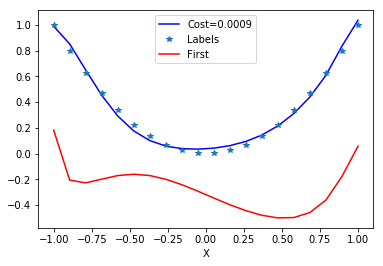

Cost= 0.0009060968089061483
Theta= [4.71073692 6.39080075 2.61246028 2.01497619 3.95242328 1.94892174
 1.73712382 0.93573718 5.81085736 1.5651638 ]


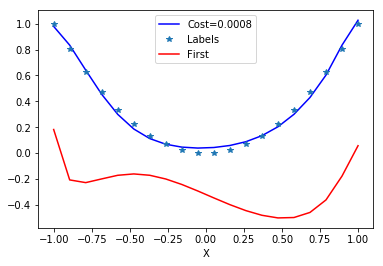

Cost= 0.000783280979776448
Theta= [4.68507443 6.39520488 2.60748289 2.01274476 3.95421533 1.96038391
 1.75106513 0.93187306 5.80668507 1.52039748]


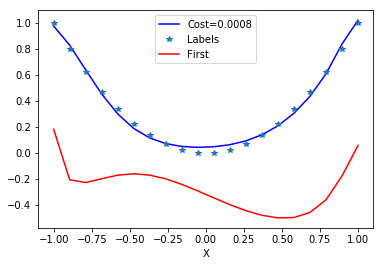

Cost= 0.0007670852718268276
Theta= [4.68274647 6.39689633 2.6044481  2.01261    3.95256129 1.96226866
 1.75414374 0.93170722 5.80645772 1.51446667]


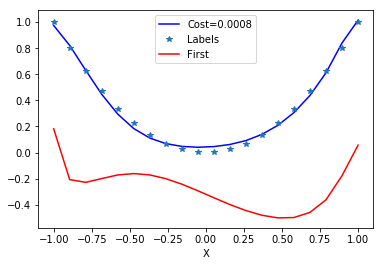

Cost= 0.0007510639923384789
Theta= [4.67985224 6.3983373  2.60015806 2.01176598 3.95201036 1.96542993
 1.75915647 0.93202931 5.80753833 1.50620664]


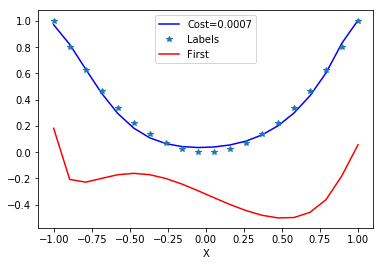

Cost= 0.0007199163163267
Theta= [4.67565404 6.39950712 2.59808449 2.01201173 3.95294823 1.97347966
 1.76384646 0.93251346 5.81075045 1.49782675]


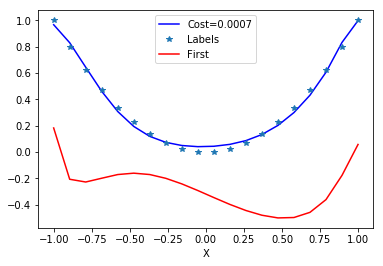

Cost= 0.0007004918684982906
Theta= [4.67101065 6.40247602 2.59585239 2.01344307 3.95131541 1.9824022
 1.76792343 0.93230666 5.81296799 1.49025894]


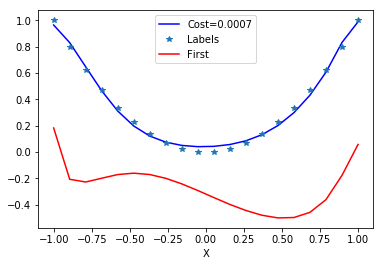

Cost= 0.0006931305039854491
Theta= [4.66599944 6.40581918 2.59165694 2.01366388 3.95059484 1.9913485
 1.77419276 0.93225461 5.81627778 1.48219885]


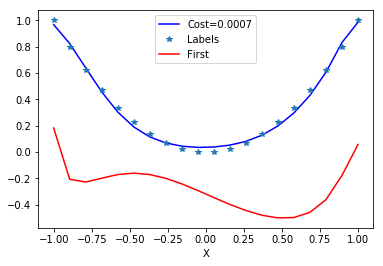

Cost= 0.0006667112327751766
Theta= [4.66444035 6.40681091 2.58874133 2.01242327 3.95153743 1.99320471
 1.77782567 0.93242338 5.81811687 1.47977911]


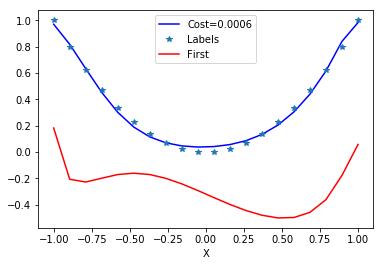

Cost= 0.0006413132102307574
Theta= [4.66207343 6.41017752 2.58393722 2.01142143 3.95016916 1.99483905
 1.78220198 0.9317363  5.81911146 1.47831709]


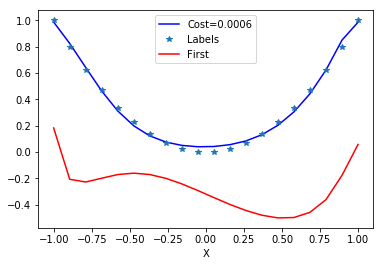

Cost= 0.0005953831266382724
Theta= [4.65041774 6.41985085 2.57786556 2.01078037 3.95239907 2.0053845
 1.7901578  0.92757286 5.82455764 1.48155015]


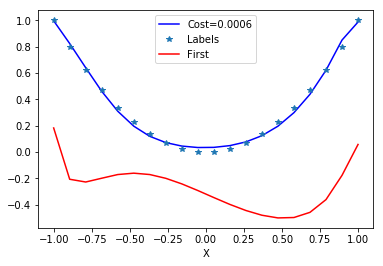

Cost= 0.0005703177974735862
Theta= [4.64455693 6.42369423 2.57444576 2.00974653 3.95548485 2.01038719
 1.79496943 0.92595916 5.82844331 1.48311158]
         Current function value: 0.000570
         Iterations: 50
         Function evaluations: 1116
         Gradient evaluations: 93


In [15]:
from scipy.optimize import minimize
import math
options={'maxiter': 50, 'disp': True}
args=(data_in,data_out,N,D,T,Hamiltonian)
Theta_out=minimize(loss,Theta,args=args, callback=callback,method='CG', options=options)

Show the final results

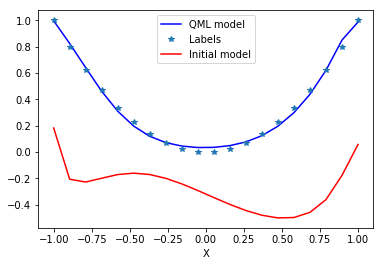

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
#qfun(j,Theta,N,D,T)
out=[qfun(j,Theta_out.x,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,"b",label="QML model")
plt.plot(data_in,data_in*data_in,"*", label="Labels")
out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,"r",label="Initial model")
plt.legend()
plt.xlabel("X")
plt.show()

In [17]:
print(alpha)

[0.7658423  0.58552958 0.61302988]


In [18]:
print(J)

[-0.14226008  0.46159572 -0.87514394]


In [19]:
print(Theta_out.x)

[4.64455693 6.42369423 2.57444576 2.00974653 3.95548485 2.01038719
 1.79496943 0.92595916 5.82844331 1.48311158]
